In [17]:
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import scipy.integrate as integrate
import matplotlib.gridspec as gridspec
import itertools
from tabulate import tabulate

def g_0n(D, Num_max, NFock ):
    """
    returns a D-squeezed 0-ancilla
    """

    r=np.log(1/D)
    psi0=qt.squeeze(NFock, r) * qt.basis(NFock,0)
    psi = qt.Qobj()
    for n in np.arange(-Num_max, Num_max+1):
        psi+=np.exp(-2*np.pi*D**2 * n**2) * qt.displace(NFock, n*np.sqrt(2*np.pi)) * psi0
    return psi.unit()

def Plot_W(rho, res, qmax, name_plot, name, smoothing=False, smooth_center=0,smooth_rad=0, smooth_asymmetry=1, showfig=True):
    
    fontsize=18
    
    xvec = np.linspace(-qmax,qmax,res)
    W=qt.wigner(rho,xvec,xvec,'clenshaw')
    Pq=integrate.simps(W,axis=0)
    Pp=integrate.simps(W,axis=1)

    if smoothing:
    ##smoothing the cutoff-error
        for i in range(res):
            for j in range(res):
                if np.sqrt((xvec[i]/smooth_asymmetry-np.real(smooth_center))**2+(smooth_asymmetry*xvec[j]-np.imag(smooth_center))**2)>=smooth_rad:
                    W[i,j]=0

    gs = gridspec.GridSpec(2, 2,
                           width_ratios=[4, 1],
                           height_ratios=[1, 4]
                           )

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax4 = plt.subplot(gs[3])

    cs=ax3.contourf(xvec, xvec, W, 100, cmap = 'RdBu_r')
    ax3.set_xlabel(r'$q/\sqrt{\pi}$', fontsize=fontsize)
    ax3.set_ylabel(r'$p/\sqrt{\pi}$', fontsize=fontsize)

    tick_max=np.floor(qmax/np.sqrt(np.pi))
    tick_num=np.arange(-tick_max,tick_max+1,1)
    ticks=tick_num*np.sqrt(np.pi)
    tick_lab=[int(x) for x in tick_num]
    ax3.set_xticks(ticks)
    ax3.set_xticklabels(tick_lab)
    ax3.set_yticks(ticks)
    ax3.set_yticklabels(tick_lab)

    ax1.plot(xvec,Pq)
    ax1.set_ylabel(r'$P(q)$', fontsize=fontsize)
    ax1.set_xticks([], [])
    ax1.set_yticks([], [])
    ax4.set_xticks([], [])
    ax4.set_yticks([], [])
    ax4.plot(Pp,xvec)
    ax4.set_xlabel(r'$P(p)$', fontsize=fontsize)
    ax2.text(0.5, 0.5, name_plot,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=20, color='black')

    ax2.set_axis_off()
    plt.tight_layout()
    if showfig==True:
        plt.show()
    else:
        plt.savefig('Wigner_%s.png'%(name))
        plt.clf()
        plt.cla()
    
    
def Disp(n,m):
    return qt.displace(NFock,n*np.sqrt(np.pi/2)+1j*m*np.sqrt(np.pi/2))

def Prob(n,m, N):
    return 2**(-4*N)*sp.special.binom(2*N,n+N)*sp.special.binom(2*N,m+N)

def moment(X, N):
    square = itertools.product(range(-N,N+1,1),range(-N,N+1,1))
    moment = sum(Prob(n,m,N)*np.abs(n*np.sqrt(2*np.pi)+1j*m*np.sqrt(2*np.pi))**X for n,m in square)
    
    return moment

def chan_twirl(S,N):
    square=itertools.product(range(-N,N+1,1),range(-N,N+1,1))
    Twirled = sum(Prob(n,m,N)*qt.to_super(Disp(-n,-m))*S*qt.to_super(Disp(n,m)) for n,m in square)
    return Twirled

def state_twirl(N):
    square=itertools.product(range(-N,N+1,1),range(-N,N+1,1))
    Twirl = sum(Prob(n,m,N)*qt.to_super(Disp(n,m)) for n,m in square)
    return Twirl

def state_twirl_pure(operator, N):
    square=itertools.product(range(-N,N+1,1),range(-N,N+1,1))
    Twirled = sum(Prob(n,m,N)*Disp(n,m)*operator*Disp(n,m).dag() for n,m in square)
    return Twirled

def holevophase(state, quadrature):
    """
    returns estimated peakwidth Delta and circular stabilizer mean phi
    as in eq. (1), Terhal B. M., Weigand D. J.,	arXiv:1909.10075
    """
    if quadrature=='q':
        exp_q=qt.expect(Stabilizer_q, state)
        Delta, phi= np.sqrt(np.log(1/np.abs(exp_q))/np.pi), np.angle(exp_q)/(2*np.sqrt(np.pi))
        
    elif quadrature=='p':
        exp_p=qt.expect(Stabilizer_p, state)
        Delta, phi=np.sqrt(np.log(1/np.abs(exp_p))/np.pi), np.angle(exp_p)/(2*np.sqrt(np.pi))
        
    return Delta, phi

def corr_rot(state):
    RANGE=np.linspace(0,np.pi/2,200)
    Z_list=[]

    for ang in RANGE:
        corr=(1j*ang*qt.num(NFock)).expm()
        GKP_corr=corr*state*(corr.dag())
        Z_list+=[np.abs(qt.expect(Z, GKP_corr))]

    opt_index=Z_list.index(max(Z_list))    
    opt_ang=RANGE[opt_index]

    corr=(1j*opt_ang*qt.num(NFock)).expm()
    GKP_corr=corr*state*(corr.dag())
    
    return GKP_corr

In [18]:
kappa=0.2
omega=1
offset=3
K=0.03
T=1
E=1
V=E
V_q=V
V_p=V


NFock=100

Stabilizer_q=qt.displace(NFock,1j*np.sqrt(2*np.pi))
Stabilizer_p=qt.displace(NFock,np.sqrt(2*np.pi))
Z=qt.displace(NFock,1j*np.sqrt(np.pi/2))
X=qt.displace(NFock,np.sqrt(np.pi/2))


a=qt.destroy(NFock)
a_dag=a.dag()

H_free=E/2*(qt.position(NFock)**2+qt.momentum(NFock)**2)
H_K=K*qt.num(NFock)**2
H_Cass=K*(a**4-offset**4).dag()*(a**4-offset**4)#+K*np.abs(offset)**2

H_stab=-V_q*(2*np.sqrt(np.pi)*qt.position(NFock)).cosm()-V_p*(2*np.sqrt(np.pi)*qt.momentum(NFock)).cosm()

#H_Par=-(1j*np.pi*qt.num(NFock)).expm()

In [19]:
from scipy.special import eval_laguerre

def H_2cat(alpha):
    C_p=(qt.coherent(NFock,alpha)+qt.coherent(NFock,-alpha)).unit()
    C_m=(qt.coherent(NFock,alpha)-qt.coherent(NFock,-alpha)).unit()
    
    H=-(qt.ket2dm(C_p)-qt.ket2dm(C_m))
    
    return H

def H_4cat(alpha):
    
    C_p=(qt.coherent(NFock,alpha)+qt.coherent(NFock,-alpha)).unit()
    C_m=(qt.coherent(NFock,alpha)-qt.coherent(NFock,-alpha)).unit()
    C_ip=(qt.coherent(NFock,1j*alpha)+qt.coherent(NFock,-1j*alpha)).unit()
    C_im=(qt.coherent(NFock,1j*alpha)-qt.coherent(NFock,-1j*alpha)).unit()
    
    C_0=(C_p+C_ip).unit()
    C_1=(C_m+-1j*C_im).unit()
    C_2=(C_p-C_ip).unit()
    C_3=(C_m+1j*C_im).unit()
    
    H=-(qt.ket2dm(C_0)+qt.ket2dm(C_2)-qt.ket2dm(C_1)-qt.ket2dm(C_3))
    
    return H
    
def H_approx_Par(phi):
    H=-np.exp(-phi**2/2)*sum(eval_laguerre(n, phi**2)*qt.fock_dm(NFock,n) for n in range(NFock))

    return H

def H_frust(x):
    
    return (-qt.num(NFock)/x).expm()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


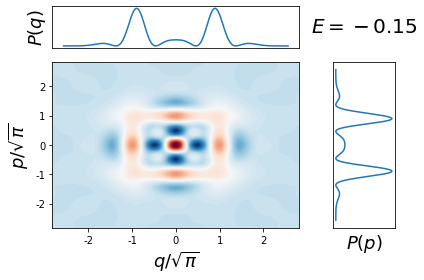

q: 0.4460607701809182
p: 0.44606077018091816


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


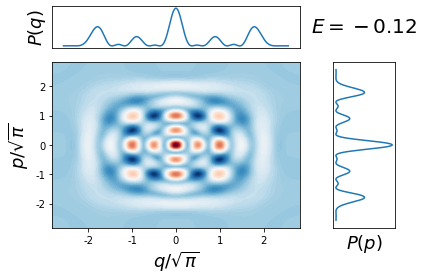

q: 0.3652409292354892
p: 0.3652409292354897


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


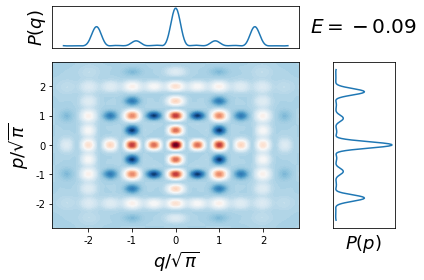

q: 0.28538536758199756
p: 0.285385367581998


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


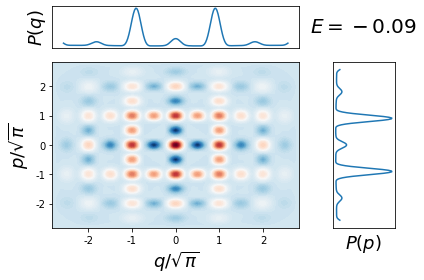

q: 0.2818672598672534
p: 0.2818672598672533


In [21]:
NRANGE=[1,5]
EV=[]
Dq=np.zeros((2,len(NRANGE)))
Dp=np.zeros((2,len(NRANGE)))

for n in range(len(NRANGE)):
    N=NRANGE[n]
    H_eff_par=state_twirl_pure(H_approx_Par(np.sqrt(2*np.pi)), N)

    EV_P, ES_P=H_eff_par.eigenstates()
    EV+=[EV_P]
    

    for i in range(2):

        Dq[i,n]=holevophase(qt.ket2dm(ES_P[i].unit()),'q')[0]
        Dp[i,n]=holevophase(qt.ket2dm(ES_P[i].unit()),'p')[0]

        #Plot_W(ES_P[i], 200, 5, r'$\Delta_{q/p}=%.2f$'%(Dq[i,n]), 'hJJ_proj_log_N%i_EV%i'%(N,i), showfig=False)
        Plot_W(ES_P[i], 200, 5, r'$E=%.2f$'%(EV_P[i]), 'hJJ_proj_log_N%i_EV%i'%(N,i), showfig=True)
        print('q:',Dq[i,n])
        print('p:',Dp[i,n])
        


In [6]:
EV=np.asarray(EV)
NRANGE=np.asarray(NRANGE)

In [7]:
Dq.shape
Dp.shape

(2, 3)

In [8]:
Dq

array([[0.44366307, 0.35352948, 0.37516723],
       [0.36082206, 0.36750811, 0.30665371]])

In [9]:
EV.shape

(3, 20)

In [10]:
temp=np.concatenate((NRANGE[:,None],EV), axis=1)

In [53]:
temp

array([[ 1.00000000e+00+0.j, -2.91082593e-01+0.j, -2.60841431e-01+0.j,
        -2.23257705e-01+0.j, -2.17313957e-01+0.j, -2.15285975e-01+0.j,
        -2.14036127e-01+0.j, -2.12790308e-01+0.j, -2.10113371e-01+0.j,
        -2.09223841e-01+0.j, -2.08696115e-01+0.j, -2.08370441e-01+0.j,
        -2.07669239e-01+0.j, -2.07628387e-01+0.j, -2.07555304e-01+0.j,
        -2.07518507e-01+0.j, -2.07504113e-01+0.j, -2.07445325e-01+0.j,
        -2.07383657e-01+0.j, -2.07377082e-01+0.j, -2.07375024e-01+0.j,
        -2.07372884e-01+0.j, -2.07116733e-01+0.j, -2.07008899e-01+0.j,
        -2.06720687e-01+0.j, -2.06720612e-01+0.j, -2.06716109e-01+0.j,
        -2.06716048e-01+0.j, -2.06015408e-01+0.j, -2.06015252e-01+0.j,
        -2.06014963e-01+0.j, -2.06014807e-01+0.j, -2.03428650e-01+0.j,
        -2.03014406e-01+0.j, -2.01857361e-01+0.j, -2.01275766e-01+0.j,
        -1.96319105e-01+0.j, -1.89477768e-01+0.j, -1.85467435e-01+0.j,
        -1.81733483e-01+0.j, -1.79776092e-01+0.j, -1.69252871e-01+0.j,
      

In [56]:
#save data
headerEV=["N"]+["EV_%i"%(i) for i in range(len(EV[0]))]
temp=np.concatenate((NRANGE[:,None],EV.real), axis=1)

file=open('spectrum.txt','w')
file.write(tabulate(temp,headerEV,tablefmt="plain"))
file.close()

In [81]:
#save data
X=np.arange(2)

headerDq=["EV"]+["Dq_%i"%(i) for i in range(len(NRANGE))]
temp=np.concatenate([X[:,None],Dq], axis=1)

file=open('Delta_q.txt','w')
file.write(tabulate(temp,headerDq,tablefmt="plain"))
file.close()

headerDp=["EV"]+["Dp_%i"%(i) for i in range(len(NRANGE))]
temp=np.concatenate([X[:,None],Dp], axis=1)

file=open('Delta_p.txt','w')
file.write(tabulate(temp,headerDp,tablefmt="plain"))
file.close()

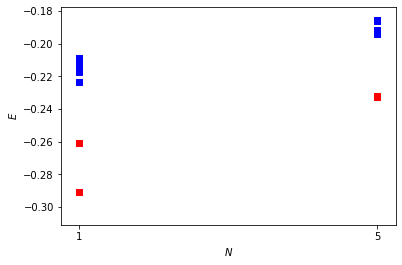

In [36]:
EV-=np.max(EV).real
NRANGE=[1,5]
fig=plt.figure("spectrum")
for i in range(10):
    if i<=1:
        plt.scatter([1,5],EV[:,i], c='r', marker='s')
    else:
        plt.scatter([1,5],EV[:,i], c='b', marker='s')
    
    plt.xlabel(r"$N$")
    plt.ylabel(r"$E$")
    plt.xticks(NRANGE, ["%i"%(i) for i in NRANGE])
    plt.savefig("spectrum.png")

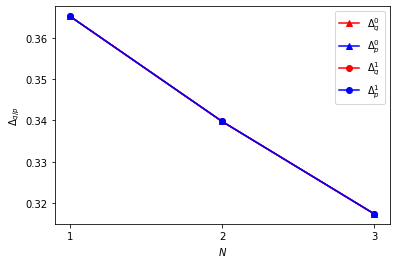

In [85]:
colors=['r','b']
markers=['^','o']
fig=plt.figure("Delta_qp")

for i in range(2):
    plt.plot(NRANGE, Dq[i,:],c='r', marker=markers[i], label='$\Delta_q^{%i}$'%(i))
    plt.plot(NRANGE, Dp[i,:],c='b', marker=markers[i], label='$\Delta_p^{%i}$'%(i))
    
    
    plt.xlabel(r"$N$")
    plt.ylabel(r"$\Delta_{q/p}$")
    plt.xticks(NRANGE, ["%i"%(i) for i in NRANGE])
    plt.legend()
    plt.savefig("deltas.png")

In [60]:
Dq[0,:]

IndexError: invalid index to scalar variable.